In [1]:
import os

%matplotlib inline
import string
import sys
import seaborn as sn

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os

%matplotlib inline
import string
import sys
from collections import deque

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import statistics

sys.path.append("code/.")
from sklearn import datasets
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.metrics import make_scorer, mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.dummy import DummyClassifier, DummyRegressor
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.model_selection import (
    GridSearchCV,
    RandomizedSearchCV,
    cross_val_score,
    cross_validate,
    train_test_split,
)
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder, StandardScaler
from sklearn.svm import SVC, SVR
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import average_precision_score
from catboost import CatBoostClassifier, CatBoostRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from xgboost import XGBClassifier, XGBRegressor
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.ensemble import StackingClassifier
import eli5

## Fantasy Baseball 2023 Pitcher Projections
Following up on the batter projections, I will now be creating projections for pitchers. This will follow a similar process to the batter projections, utilizing metrics from the previous year to predict fantasy points for the current year. Similarily to the hitter projections, 2023 projected innings will be taken from Razzball, and team factors will be calculated and applied to each pitcher. The main limitation from this model stems from closers, as saves severely inflate their projected fantasy scores. As the data is not aware who will be a closer in 2023, changes will be made to account for who is and isn't closing in 2023. 

In [2]:
os.chdir("/Users/matthewgillies/FantasyPreds2023")
data = pd.read_csv("data/Pitchfull.csv", index_col = 0)
data.head()

year  p_k_percent  p_bb_percent   xslg  xwoba   xobp  \
player                                                                   
Wainwright, Adam  2022         21.0           6.0  0.388  0.302  0.305   
Greinke, Zack     2022         17.2           5.2  0.430  0.320  0.307   
Jansen, Kenley    2022         30.9          12.9  0.270  0.260  0.295   
Chavez, Jesse     2022         27.1           8.3  0.345  0.271  0.277   
Detwiler, Ross    2022         27.1           8.7  0.392  0.316  0.317   

                  xwobacon  exit_velocity_avg  launch_angle_avg  \
player                                                            
Wainwright, Adam     0.353               88.2              10.0   
Greinke, Zack        0.365               88.3              10.6   
Jansen, Kenley       0.310               84.0              19.8   
Chavez, Jesse        0.335               90.9              10.4   
Detwiler, Ross       0.383               88.3              15.3   

                  sweet_spot_percent  ...  edge_percent  whiff_percent  \
player                                ...                                
Wainwright, Adam                34.3  ...          45.4           19.7   
Greinke, Zack                   35.3  ...          42.9           21.8   
Jansen, Kenley                  30.1  ...          41.5           33.1   
Chavez, Jesse                   29.1  ...          41.7           17.7   
Detwiler, Ross                  30.2  ...          44.9           24.0   

                  swing_percent  f_strike_percent  groundballs_percent  \
player                                                                   
Wainwright, Adam           43.8              64.4                 48.7   
Greinke, Zack              46.0              66.0                 45.6   
Jansen, Kenley             50.1              62.8                 37.9   
Chavez, Jesse              43.9              65.2                 43.0   
Detwiler, Ross             45.0              53.7                 39.6   

                  flyballs_percent  linedrives_percent  popups_percent  \
player                                                                   
Wainwright, Adam              21.5                25.4             4.4   
Greinke, Zack                 23.9                25.0             5.4   
Jansen, Kenley                30.1                19.0            13.1   
Chavez, Jesse                 29.1                26.7             1.2   
Detwiler, Ross                31.7                18.7            10.1   

                  Fpointsper   S  
player                            
Wainwright, Adam    1.624477   0  
Greinke, Zack       1.299270   0  
Jansen, Kenley      5.828125  41  
Chavez, Jesse       1.943560   0  
Detwiler, Ross      1.544061   1  

[5 rows x 26 columns]

In [3]:
## Checking for NA Values
data.isna().any()

year                     False
p_k_percent               True
p_bb_percent              True
xslg                      True
xwoba                     True
xobp                      True
xwobacon                  True
exit_velocity_avg         True
launch_angle_avg          True
sweet_spot_percent        True
barrel_batted_rate        True
z_swing_percent           True
z_swing_miss_percent      True
oz_swing_percent          True
oz_swing_miss_percent     True
out_zone_percent          True
edge_percent              True
whiff_percent             True
swing_percent             True
f_strike_percent          True
groundballs_percent       True
flyballs_percent          True
linedrives_percent        True
popups_percent            True
Fpointsper               False
S                        False
dtype: bool

In [4]:
## Dropping NA rows
data = data.dropna()

In [5]:
data.shape

(1118, 26)

In [6]:
## Removing the year column as the model should not take the year into account for future predictions
data = data.drop(columns = 'year')

In [7]:
## Data splitting with 70/30 split
X = data.drop(columns = "Fpointsper")
y = data["Fpointsper"]
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 123)
X_train.head()

p_k_percent  p_bb_percent   xslg  xwoba   xobp  xwobacon  \
player                                                                       
Melancon, Mark           17.8           8.0  0.459  0.356  0.361     0.408   
Bassitt, Chris           20.1           9.3  0.368  0.306  0.314     0.332   
Canning, Griffin         23.5           9.7  0.423  0.320  0.311     0.377   
Springs, Jeffrey         22.0           9.9  0.409  0.326  0.335     0.379   
Hughes, Jared            18.7           9.3  0.400  0.314  0.322     0.346   

                  exit_velocity_avg  launch_angle_avg  sweet_spot_percent  \
player                                                                      
Melancon, Mark                 88.8               6.7                34.4   
Bassitt, Chris                 85.8              11.8                32.9   
Canning, Griffin               88.9              18.9                30.4   
Springs, Jeffrey               86.7              17.6                41.1   
Hughes, Jared                  89.7               1.3                25.2   

                  barrel_batted_rate  ...  out_zone_percent  edge_percent  \
player                                ...                                   
Melancon, Mark                   7.0  ...              56.1          46.2   
Bassitt, Chris                   6.4  ...              49.1          41.0   
Canning, Griffin                 8.9  ...              55.1          40.6   
Springs, Jeffrey                 6.3  ...              46.5          45.5   
Hughes, Jared                    6.8  ...              59.9          45.4   

                  whiff_percent  swing_percent  f_strike_percent  \
player                                                             
Melancon, Mark             23.3           45.9              57.6   
Bassitt, Chris             17.3           44.4              59.3   
Canning, Griffin           27.1           45.1              56.3   
Springs, Jeffrey           27.0           44.8              60.7   
Hughes, Jared              22.5           47.5              60.1   

                  groundballs_percent  flyballs_percent  linedrives_percent  \
player                                                                        
Melancon, Mark                   51.6              13.3                31.3   
Bassitt, Chris                   44.3              22.1                27.1   
Canning, Griffin                 36.7              28.5                23.4   
Springs, Jeffrey                 32.6              24.2                30.5   
Hughes, Jared                    60.2              15.5                21.4   

                  popups_percent   S  
player                                
Melancon, Mark               3.9  12  
Bassitt, Chris               6.4   0  
Canning, Griffin            11.4   0  
Springs, Jeffrey            12.6   0  
Hughes, Jared                2.9   0  

[5 rows x 24 columns]

In [8]:
## Further inspecting the data
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 894 entries, Melancon, Mark to Wendelken, J.B.
Data columns (total 24 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   p_k_percent            894 non-null    float64
 1   p_bb_percent           894 non-null    float64
 2   xslg                   894 non-null    float64
 3   xwoba                  894 non-null    float64
 4   xobp                   894 non-null    float64
 5   xwobacon               894 non-null    float64
 6   exit_velocity_avg      894 non-null    float64
 7   launch_angle_avg       894 non-null    float64
 8   sweet_spot_percent     894 non-null    float64
 9   barrel_batted_rate     894 non-null    float64
 10  z_swing_percent        894 non-null    float64
 11  z_swing_miss_percent   894 non-null    float64
 12  oz_swing_percent       894 non-null    float64
 13  oz_swing_miss_percent  894 non-null    float64
 14  out_zone_percent       894 non-null   

In [9]:
X_train.describe()

p_k_percent  p_bb_percent        xslg       xwoba        xobp  \
count   894.000000    894.000000  894.000000  894.000000  894.000000   
mean     23.904810      8.437808    0.395343    0.308942    0.310809   
std       5.887637      2.738409    0.063820    0.035000    0.033201   
min       9.100000      2.000000    0.196000    0.205000    0.194000   
25%      19.725000      6.700000    0.352250    0.284000    0.288000   
50%      23.300000      8.200000    0.395000    0.309500    0.311000   
75%      27.500000      9.900000    0.434000    0.332000    0.334000   
max      48.600000     19.500000    0.619000    0.429000    0.418000   

         xwobacon  exit_velocity_avg  launch_angle_avg  sweet_spot_percent  \
count  894.000000         894.000000        894.000000          894.000000   
mean     0.367639          88.351454         12.367562           32.993065   
std      0.037591           1.600466          5.566974            4.283516   
min      0.240000          82.700000        -10.900000           14.200000   
25%      0.343250          87.400000          9.000000           30.600000   
50%      0.366500          88.400000         12.350000           33.100000   
75%      0.390000          89.400000         16.000000           35.800000   
max      0.513000          94.400000         29.600000           49.300000   

       barrel_batted_rate  ...  out_zone_percent  edge_percent  whiff_percent  \
count          894.000000  ...        894.000000    894.000000     894.000000   
mean             7.037584  ...         51.314318     42.592953      26.243065   
std              2.471943  ...          3.343087      2.208075       5.166371   
min              0.700000  ...         40.300000     34.900000      10.300000   
25%              5.400000  ...         49.000000     41.200000      22.600000   
50%              6.900000  ...         51.200000     42.600000      25.800000   
75%              8.600000  ...         53.500000     44.100000      29.675000   
max             16.200000  ...         62.800000     51.400000      47.800000   

       swing_percent  f_strike_percent  groundballs_percent  flyballs_percent  \
count     894.000000        894.000000           894.000000        894.000000   
mean       47.225391         60.911409            44.388479         23.922483   
std         3.154973          4.660316             8.318364          5.769449   
min        36.100000         44.400000            21.700000          7.700000   
25%        45.200000         57.800000            38.700000         20.000000   
50%        47.200000         61.200000            44.300000         24.000000   
75%        49.275000         64.200000            49.700000         27.800000   
max        57.400000         74.400000            76.900000         45.800000   

       linedrives_percent  popups_percent           S  
count          894.000000      894.000000  894.000000  
mean            24.335682        7.353132    2.173378  
std              3.713366        3.131011    6.178216  
min             10.000000        0.000000    0.000000  
25%             22.200000        5.200000    0.000000  
50%             24.400000        7.000000    0.000000  
75%             26.500000        9.100000    1.000000  
max             40.800000       20.000000   42.000000  

[8 rows x 24 columns]

In [10]:
## Analyzing correlations of features
corr_matrix = X_train.corr()
plt.figure(figsize = (100,100))
plt.rcParams.update({'font.size': 50})
sn.heatmap(corr_matrix, annot = True)

<AxesSubplot: >

There are many strong correlations within the dataset, which comes as expected due to the similarities and differences of many of the features. For example, groundball and flyball percentages have a strong negative correlation, which is intuitive as they are essentially opposites. On the other side of the spectrum, launch angle and flyball percentage have a very strong positive correlation. This is due to the fact that as launch angle increases, more flyballs will be given up, increasing flyball percentage. 

array([[<AxesSubplot: title={'center': 'p_k_percent'}>,
        <AxesSubplot: title={'center': 'p_bb_percent'}>,
        <AxesSubplot: title={'center': 'xslg'}>,
        <AxesSubplot: title={'center': 'xwoba'}>,
        <AxesSubplot: title={'center': 'xobp'}>],
       [<AxesSubplot: title={'center': 'xwobacon'}>,
        <AxesSubplot: title={'center': 'exit_velocity_avg'}>,
        <AxesSubplot: title={'center': 'launch_angle_avg'}>,
        <AxesSubplot: title={'center': 'sweet_spot_percent'}>,
        <AxesSubplot: title={'center': 'barrel_batted_rate'}>],
       [<AxesSubplot: title={'center': 'z_swing_percent'}>,
        <AxesSubplot: title={'center': 'z_swing_miss_percent'}>,
        <AxesSubplot: title={'center': 'oz_swing_percent'}>,
        <AxesSubplot: title={'center': 'oz_swing_miss_percent'}>,
        <AxesSubplot: title={'center': 'out_zone_percent'}>],
       [<AxesSubplot: title={'center': 'edge_percent'}>,
        <AxesSubplot: title={'center': 'whiff_percent'}>,
      

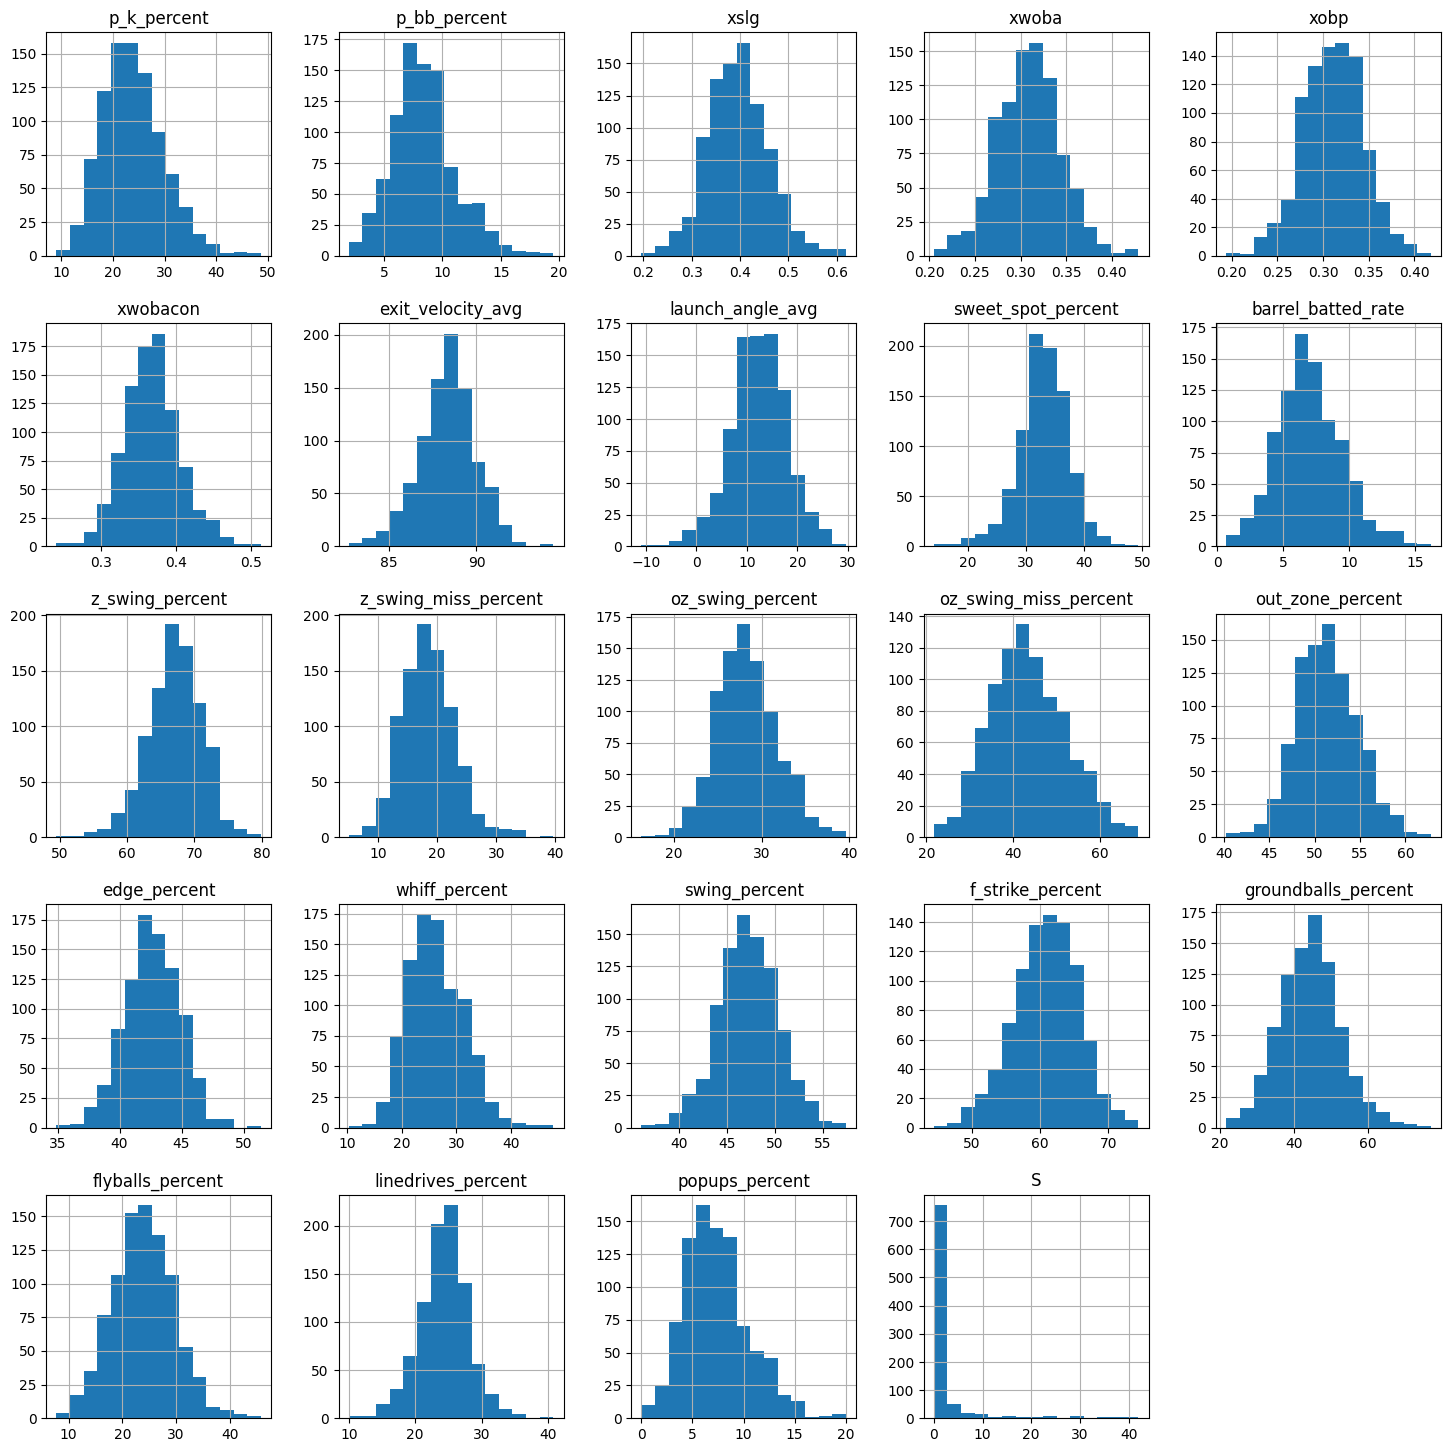

In [11]:
## Examining histograms and distributions of features
plt.rcParams.update({'font.size': 10})
X_train.hist(bins = 15, figsize = (18,18))

All features besides saves appear to be normally distributed, which is to be expected with metrics. Saves has a heavily right-tailed distribution due to the fact that only closers accumulate saves, with all starting pitchers and relievers rarely accumulating saves. 

In [40]:
## Preprocessing
colnames = list(X_train.columns)
## setting category names for preprocessor
scaling_feats = colnames
colnames

['p_k_percent',
 'p_bb_percent',
 'xslg',
 'xwoba',
 'xobp',
 'xwobacon',
 'exit_velocity_avg',
 'launch_angle_avg',
 'sweet_spot_percent',
 'barrel_batted_rate',
 'z_swing_percent',
 'z_swing_miss_percent',
 'oz_swing_percent',
 'oz_swing_miss_percent',
 'out_zone_percent',
 'edge_percent',
 'whiff_percent',
 'swing_percent',
 'f_strike_percent',
 'groundballs_percent',
 'flyballs_percent',
 'linedrives_percent',
 'popups_percent',
 'S']

In [13]:
## Creating column transformer
ct = make_column_transformer(
    (StandardScaler(), scaling_feats))

ct

ColumnTransformer(transformers=[('standardscaler', StandardScaler(),
                                 ['p_k_percent', 'p_bb_percent', 'xslg',
                                  'xwoba', 'xobp', 'xwobacon',
                                  'exit_velocity_avg', 'launch_angle_avg',
                                  'sweet_spot_percent', 'barrel_batted_rate',
                                  'z_swing_percent', 'z_swing_miss_percent',
                                  'oz_swing_percent', 'oz_swing_miss_percent',
                                  'out_zone_percent', 'edge_percent',
                                  'whiff_percent', 'swing_percent',
                                  'f_strike_percent', 'groundballs_percent',
                                  'flyballs_percent', 'linedrives_percent',
                                  'popups_percent', 'S'])])

In [14]:
# Fitting X_train with scaled values, transforming both X_train and X_test
transformed_X_train = ct.fit_transform(X_train)
transformed_X_test = ct.transform(X_test)

In [15]:
## Creating transformed data frames
X_train_transformed = pd.DataFrame(transformed_X_train, columns = colnames)
X_test_transformed = pd.DataFrame(transformed_X_test, columns = colnames)
X_train_transformed.head()

p_k_percent  p_bb_percent      xslg     xwoba      xobp  xwobacon  \
0    -1.037467     -0.159966  0.998005  1.345256  1.512573  1.074299   
1    -0.646599      0.315028 -0.428688 -0.084098  0.096173 -0.948597   
2    -0.068794      0.461180  0.433599  0.316121  0.005764  0.249170   
3    -0.323708      0.534256  0.214107  0.487643  0.729033  0.302404   
4    -0.884518      0.315028  0.073006  0.144598  0.337262 -0.575959   

   exit_velocity_avg  launch_angle_avg  sweet_spot_percent  \
0           0.280416         -1.018639            0.328637   
1          -1.595086         -0.102009           -0.021738   
2           0.342933          1.174084           -0.605698   
3          -1.032436          0.940433            1.893648   
4           0.843067         -1.989188           -1.820333   

   barrel_batted_rate  ...  out_zone_percent  edge_percent  whiff_percent  \
0           -0.015213  ...          1.432317      1.634485      -0.569977   
1           -0.258073  ...         -0.662728     -0.721826      -1.731984   
2            0.753844  ...          1.133025     -0.903080       0.165961   
3           -0.298549  ...         -1.440887      1.317290       0.146594   
4           -0.096166  ...          2.569627      1.271976      -0.724911   

   swing_percent  f_strike_percent  groundballs_percent  flyballs_percent  \
0      -0.420331         -0.710952             0.867425         -1.842191   
1      -0.896037         -0.345966            -0.010643         -0.316062   
2      -0.674041         -0.990060            -0.924795          0.793850   
3      -0.769182         -0.045389            -1.417956          0.048128   
4       0.087089         -0.174208             1.901861         -1.460659   

   linedrives_percent  popups_percent         S  
0            1.876523       -1.103498  1.591418  
1            0.744840       -0.304587 -0.351978  
2           -0.252118        1.293235 -0.351978  
3            1.660964        1.676712 -0.351978  
4           -0.791014       -1.423062 -0.351978  

[5 rows x 24 columns]

### Dummy Regressor

In [16]:
## Creating function that returns mean and sd of cv scores
def mean_std_cross_val_scores(model, X_train, y_train, **kwargs):
    """
    Returns mean and std of cross validation

    Parameters
    ----------
    model :
        scikit-learn model
    X_train : numpy array or pandas DataFrame
        X in the training data
    y_train :
        y in the training data

    Returns
    ----------
        pandas Series with mean scores from cross_validation
    """

    scores = cross_validate(model, X_train, y_train, **kwargs)

    mean_scores = pd.DataFrame(scores).mean()
    std_scores = pd.DataFrame(scores).std()
    out_col = []

    for i in range(len(mean_scores)):
        out_col.append((f"%0.3f (+/- %0.3f)" % (mean_scores[i], std_scores[i])))

    return pd.Series(data=out_col, index=mean_scores.index)

In [17]:
## Performing regression with dummy regressor
s = "neg_mean_absolute_percentage_error"
results = {}
dc = DummyRegressor(strategy = "mean")
pipe = make_pipeline(ct, dc)
dc.fit(X_train, y_train)
results["dummy"] = mean_std_cross_val_scores(pipe, X_train, y_train, return_train_score = True, 
                                             scoring=s)
pd.DataFrame(results)

dummy
fit_time      0.003 (+/- 0.001)
score_time    0.002 (+/- 0.000)
test_score   -0.775 (+/- 0.233)
train_score  -0.774 (+/- 0.054)

Dummy regressor is quite inaccurate with its predictions with a MAPE of 0.775 for the test set. 

### Ridge

In [18]:
pipe_linear_test = make_pipeline(ct, Ridge())

In [19]:
## Performing hyperparameter optimization for alpha in ridge
param_grid_linear = {"ridge__alpha" : [0.001,0.01,0.1,1,10,100,1000]}
random_search_linear = RandomizedSearchCV(pipe_linear_test, param_grid_linear, n_iter = 100, cv = 5, n_jobs = -1,random_state = 123,
                                  scoring=s)
random_search_linear.fit(X_train, y_train)
results_lin = pd.DataFrame(random_search_linear.cv_results_).set_index("rank_test_score").sort_index()
results_lin.T

/Applications/miniconda3/lib/python3.10/site-packages/sklearn/model_selection/_search.py:306: UserWarning: The total space of parameters 7 is smaller than n_iter=100. Running 7 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


rank_test_score                       1                      2  \
mean_fit_time                  0.004455               0.006744   
std_fit_time                   0.000888               0.002057   
mean_score_time                 0.00174               0.001761   
std_score_time                 0.000047               0.000042   
param_ridge__alpha                    1                    0.1   
params              {'ridge__alpha': 1}  {'ridge__alpha': 0.1}   
split0_test_score             -0.771551              -0.774163   
split1_test_score             -0.381753              -0.381857   
split2_test_score             -0.442718              -0.441647   
split3_test_score             -0.711968              -0.709641   
split4_test_score             -0.509205              -0.511063   
mean_test_score               -0.563439              -0.563674   
std_test_score                 0.152247               0.152531   

rank_test_score                          3                        4  \
mean_fit_time                     0.006677                 0.008773   
std_fit_time                       0.00206                 0.002506   
mean_score_time                   0.002056                 0.002332   
std_score_time                    0.000129                   0.0003   
param_ridge__alpha                    0.01                    0.001   
params              {'ridge__alpha': 0.01}  {'ridge__alpha': 0.001}   
split0_test_score                -0.775509                -0.775862   
split1_test_score                -0.381943                -0.381971   
split2_test_score                -0.441842                -0.441958   
split3_test_score                -0.708164                -0.707628   
split4_test_score                -0.511566                -0.511681   
mean_test_score                  -0.563805                 -0.56382   
std_test_score                    0.152536                 0.152499   

rank_test_score                        5                      6  \
mean_fit_time                   0.005045               0.004415   
std_fit_time                    0.001503               0.000439   
mean_score_time                 0.001756               0.001916   
std_score_time                  0.000116                0.00005   
param_ridge__alpha                    10                    100   
params              {'ridge__alpha': 10}  {'ridge__alpha': 100}   
split0_test_score              -0.770758              -0.781763   
split1_test_score              -0.381972              -0.388972   
split2_test_score              -0.445326              -0.448851   
split3_test_score              -0.716834              -0.724179   
split4_test_score              -0.504977              -0.507878   
mean_test_score                -0.563973              -0.570329   
std_test_score                  0.152846               0.154869   

rank_test_score                          7  
mean_fit_time                     0.005744  
std_fit_time                       0.00225  
mean_score_time                   0.001908  
std_score_time                    0.000095  
param_ridge__alpha                    1000  
params              {'ridge__alpha': 1000}  
split0_test_score                -0.843488  
split1_test_score                -0.433938  
split2_test_score                 -0.48117  
split3_test_score                -0.783339  
split4_test_score                -0.539988  
mean_test_score                  -0.616384  
std_test_score                    0.165442

In [20]:
## Applying ridge model with alpha = 1
pipe_linear = make_pipeline(ct, Ridge(alpha = 1))
results["linear"] = mean_std_cross_val_scores(pipe_linear, X_train, y_train, return_train_score = True, scoring = "neg_mean_absolute_percentage_error")
pd.DataFrame(results)

dummy              linear
fit_time      0.003 (+/- 0.001)   0.004 (+/- 0.001)
score_time    0.002 (+/- 0.000)   0.002 (+/- 0.000)
test_score   -0.775 (+/- 0.233)  -0.563 (+/- 0.170)
train_score  -0.774 (+/- 0.054)  -0.546 (+/- 0.041)

Ridge performs better than dummy regressor, however is still relatively inaccurate with a 0.563 MAPE

## Gradient Boosted Models

In [21]:
## Creating pipelines for the three models
pipe_rf = make_pipeline(ct, RandomForestRegressor(random_state = 123, n_jobs = -1))
pipe_xg = make_pipeline(ct, XGBRegressor(random_state = 123, eval_metric = "logloss", verbosity = 0))
pipe_cat = make_pipeline(ct, CatBoostRegressor(verbose=0, random_state=123))


In [22]:
## Hyperparameter optimization for random forest regressor
param_grid_rf = {"randomforestregressor__max_depth" : [2,4,6,8,10,12,14,16,18,20],
               "randomforestregressor__n_estimators" : [2,4,6,8,10,12,14,16,18,20]}
random_search_rf = RandomizedSearchCV(pipe_rf, param_grid_rf, n_iter = 100, cv = 5, n_jobs = -1,random_state = 123,
                                  scoring = s)
random_search_rf.fit(X_train, y_train)
results_rf = pd.DataFrame(random_search_rf.cv_results_).set_index("rank_test_score").sort_index()
results_rf.T

rank_test_score                                                                          1    \
mean_fit_time                                                                       0.084387   
std_fit_time                                                                        0.011118   
mean_score_time                                                                     0.018939   
std_score_time                                                                      0.006902   
param_randomforestregressor__n_estimators                                                 12   
param_randomforestregressor__max_depth                                                    12   
params                                     {'randomforestregressor__n_estimators': 12, 'r...   
split0_test_score                                                                  -0.679719   
split1_test_score                                                                   -0.38645   
split2_test_score                                                                  -0.500944   
split3_test_score                                                                   -0.67519   
split4_test_score                                                                  -0.517263   
mean_test_score                                                                    -0.551913   
std_test_score                                                                      0.111989   

rank_test_score                                                                          2    \
mean_fit_time                                                                       0.098196   
std_fit_time                                                                        0.027499   
mean_score_time                                                                     0.040969   
std_score_time                                                                      0.025536   
param_randomforestregressor__n_estimators                                                 12   
param_randomforestregressor__max_depth                                                    18   
params                                     {'randomforestregressor__n_estimators': 12, 'r...   
split0_test_score                                                                  -0.676637   
split1_test_score                                                                  -0.378931   
split2_test_score                                                                  -0.511432   
split3_test_score                                                                  -0.699022   
split4_test_score                                                                  -0.511523   
mean_test_score                                                                    -0.555509   
std_test_score                                                                      0.118596   

rank_test_score                                                                          3    \
mean_fit_time                                                                       0.117667   
std_fit_time                                                                        0.024199   
mean_score_time                                                                     0.031907   
std_score_time                                                                      0.029288   
param_randomforestregressor__n_estimators                                                 12   
param_randomforestregressor__max_depth                                                    16   
params                                     {'randomforestregressor__n_estimators': 12, 'r...   
split0_test_score                                                                  -0.687258   
split1_test_score                                                                   -0.38687   
split2_test_score                                                                  -0.512218   
split3_test_score                                             

In [23]:
results_rf.T.iloc[6][1]

{'randomforestregressor__n_estimators': 12,
 'randomforestregressor__max_depth': 12}

Best parameter for random forest are n_estimators = 12 and max_depth = 12

In [24]:
pipe_rf1 = make_pipeline(ct, RandomForestRegressor(random_state = 123, n_jobs = -1, n_estimators = 12, max_depth = 12))
results["Random Forest"] = mean_std_cross_val_scores(pipe_rf1, X_train, y_train, return_train_score = True, scoring = s)
pd.DataFrame(results)

dummy              linear       Random Forest
fit_time      0.003 (+/- 0.001)   0.004 (+/- 0.001)   0.031 (+/- 0.005)
score_time    0.002 (+/- 0.000)   0.002 (+/- 0.000)   0.005 (+/- 0.001)
test_score   -0.775 (+/- 0.233)  -0.563 (+/- 0.170)  -0.552 (+/- 0.125)
train_score  -0.774 (+/- 0.054)  -0.546 (+/- 0.041)  -0.262 (+/- 0.020)

Random forest performs better than Ridge regression by a small margin, however the large amount of overfitting that occurs with random forest nullifies this performance. 

In [25]:
## hyperparameter optimization for XGBoost
param_grid_xgb = {"xgbregressor__max_depth" : [2,4,6,8,10,12,14,16,18,20],
               "xgbregressor__learning_rate" : [0.001,0.01,0.1,0.2,0.3,0.4]}
random_search_xgb = RandomizedSearchCV(pipe_xg, param_grid_xgb, n_iter = 40, cv = 5, n_jobs = -1,random_state = 123,
                                  scoring = s)
random_search_xgb.fit(X_train, y_train)
results_xgb = pd.DataFrame(random_search_xgb.cv_results_).set_index("rank_test_score").sort_index()
results_xgb.T

rank_test_score                                                                   1   \
mean_fit_time                                                                0.18082   
std_fit_time                                                                0.005096   
mean_score_time                                                             0.005346   
std_score_time                                                              0.002219   
param_xgbregressor__max_depth                                                      4   
param_xgbregressor__learning_rate                                               0.01   
params                             {'xgbregressor__max_depth': 4, 'xgbregressor__...   
split0_test_score                                                          -0.695099   
split1_test_score                                                          -0.360409   
split2_test_score                                                          -0.487093   
split3_test_score                                                          -0.632495   
split4_test_score                                                          -0.527154   
mean_test_score                                                             -0.54045   
std_test_score                                                              0.116471   

rank_test_score                                                                   2   \
mean_fit_time                                                               0.280981   
std_fit_time                                                                0.024804   
mean_score_time                                                             0.003336   
std_score_time                                                              0.001091   
param_xgbregressor__max_depth                                                      6   
param_xgbregressor__learning_rate                                               0.01   
params                             {'xgbregressor__max_depth': 6, 'xgbregressor__...   
split0_test_score                                                          -0.688254   
split1_test_score                                                          -0.357941   
split2_test_score                                                          -0.490431   
split3_test_score                                                          -0.640054   
split4_test_score                                                          -0.530861   
mean_test_score                                                            -0.541508   
std_test_score                                                              0.116331   

rank_test_score                                                                   3   \
mean_fit_time                                                               0.577364   
std_fit_time                                                                0.014427   
mean_score_time                                                             0.005911   
std_score_time                                                              0.003231   
param_xgbregressor__max_depth                                                     12   
param_xgbregressor__learning_rate                                               0.01   
params                             {'xgbregressor__max_depth': 12, 'xgbregressor_...   
split0_test_score                                                          -0.676292   
split1_test_score                                                          -0.353635   
split2_test_score                                                          -0.513208   
split3_test_score                                                          -0.649874   
split4_test_score                                                          -0.535259   
mean_test_score                                                            -0.545654   
std_test_score                                                              0.114856   

rank_test_score                      

In [26]:
results_xgb.T.iloc[6][1]

{'xgbregressor__max_depth': 4, 'xgbregressor__learning_rate': 0.01}

Best parameters for XGBoost are max_depth = 4 and learning_rate = 0.01

In [27]:
pipe_xgb = make_pipeline(ct, XGBRegressor(random_state = 123, eval_metric = "logloss", verbosity = 0
                                        , max_depth = 4, learning_rate = 0.01))
results["XGB"] = mean_std_cross_val_scores(pipe_xgb, X_train, y_train, return_train_score = True, scoring = s)
pd.DataFrame(results)

dummy              linear       Random Forest  \
fit_time      0.003 (+/- 0.001)   0.004 (+/- 0.001)   0.031 (+/- 0.005)   
score_time    0.002 (+/- 0.000)   0.002 (+/- 0.000)   0.005 (+/- 0.001)   
test_score   -0.775 (+/- 0.233)  -0.563 (+/- 0.170)  -0.552 (+/- 0.125)   
train_score  -0.774 (+/- 0.054)  -0.546 (+/- 0.041)  -0.262 (+/- 0.020)   

                            XGB  
fit_time      0.129 (+/- 0.038)  
score_time    0.003 (+/- 0.000)  
test_score   -0.540 (+/- 0.130)  
train_score  -0.505 (+/- 0.026)

XGBoost performs better than all of the previous models, and with only moderate overfitting this would currently be the model we would select.

In [28]:
# Hyperparameter optimization for CatBoost
param_grid_cat = {"catboostregressor__learning_rate" : [0.001,0.01,0.1,0.2],
                  "catboostregressor__n_estimators" : [10,50,100,200,300]}
random_search_cat = RandomizedSearchCV(pipe_cat, param_grid_cat, n_iter = 20, cv = 5, n_jobs = -1, random_state = 123,
                                      scoring = s)
random_search_cat.fit(X_train, y_train)
results_cat = pd.DataFrame(random_search_cat.cv_results_).set_index("rank_test_score").sort_index()
results_cat.T

rank_test_score                                                                        1   \
mean_fit_time                                                                    0.252515   
std_fit_time                                                                     0.016761   
mean_score_time                                                                  0.004832   
std_score_time                                                                   0.001625   
param_catboostregressor__n_estimators                                                  50   
param_catboostregressor__learning_rate                                                0.2   
params                                  {'catboostregressor__n_estimators': 50, 'catbo...   
split0_test_score                                                               -0.772526   
split1_test_score                                                               -0.392004   
split2_test_score                                                               -0.473745   
split3_test_score                                                               -0.685538   
split4_test_score                                                               -0.504312   
mean_test_score                                                                 -0.565625   
std_test_score                                                                   0.141091   

rank_test_score                                                                        2   \
mean_fit_time                                                                    0.957115   
std_fit_time                                                                     0.040025   
mean_score_time                                                                  0.005211   
std_score_time                                                                   0.002133   
param_catboostregressor__n_estimators                                                 200   
param_catboostregressor__learning_rate                                                0.2   
params                                  {'catboostregressor__n_estimators': 200, 'catb...   
split0_test_score                                                                -0.79595   
split1_test_score                                                               -0.378099   
split2_test_score                                                               -0.490839   
split3_test_score                                                               -0.684532   
split4_test_score                                                               -0.499121   
mean_test_score                                                                 -0.569708   
std_test_score                                                                   0.149858   

rank_test_score                                                                        3   \
mean_fit_time                                                                    1.108503   
std_fit_time                                                                      0.18443   
mean_score_time                                                                  0.002702   
std_score_time                                                                   0.000224   
param_catboostregressor__n_estimators                                                 300   
param_catboostregressor__learning_rate                                                0.2   
params                                  {'catboostregressor__n_estimators': 300, 'catb...   
split0_test_score                                                               -0.800561   
split1_test_score                                                               -0.376279   
split2_test_score                                                               -0.492087   
split3_test_score                                                               -0.683976   
split4_test_score                                                               -0.499404   

In [29]:
results_cat.T.iloc[6][1]

{'catboostregressor__n_estimators': 50,
 'catboostregressor__learning_rate': 0.2}

Best parameters for CatBoost are n_estimators = 50 and learning_rate = 0.2

In [30]:
pipe_catb = make_pipeline(ct, CatBoostRegressor(verbose=0, random_state=123, n_estimators = 50, learning_rate = 0.2))
results["CatBoost"] = mean_std_cross_val_scores(pipe_catb, X_train, y_train, return_train_score = True, scoring = s)
pd.DataFrame(results)   

dummy              linear       Random Forest  \
fit_time      0.003 (+/- 0.001)   0.004 (+/- 0.001)   0.031 (+/- 0.005)   
score_time    0.002 (+/- 0.000)   0.002 (+/- 0.000)   0.005 (+/- 0.001)   
test_score   -0.775 (+/- 0.233)  -0.563 (+/- 0.170)  -0.552 (+/- 0.125)   
train_score  -0.774 (+/- 0.054)  -0.546 (+/- 0.041)  -0.262 (+/- 0.020)   

                            XGB            CatBoost  
fit_time      0.129 (+/- 0.038)   0.071 (+/- 0.007)  
score_time    0.003 (+/- 0.000)   0.003 (+/- 0.000)  
test_score   -0.540 (+/- 0.130)  -0.566 (+/- 0.158)  
train_score  -0.505 (+/- 0.026)  -0.388 (+/- 0.017)

Catboost performs worse than the previous models on the test data with overfitting. 

### Feature Selection

In [31]:
## performing forward selection with Ridge to see if model accuracy can be improved
# pipe_forward_ridge = make_pipeline(
#     ct,
#     SequentialFeatureSelector(XGBRegressor(random_state = 123, eval_metric = "logloss", verbosity = 0
#                                         , max_depth = 4, learning_rate = 0.01), 
#                               direction="forward", 
#                               n_features_to_select='auto', 
#                               tol=None),
#     Ridge(alpha = 10),
# )

In [32]:
# results["XGBselected"] = mean_std_cross_val_scores(pipe_forward_ridge, X_train, y_train, return_train_score = True,
#                                                     scoring = s)
# pd.DataFrame(results)

Feature selection only harms the model

### Feature Importances

In [33]:
pipe_opt = make_pipeline(ct, XGBRegressor(random_state = 123, eval_metric = "logloss", verbosity = 0
                                        , max_depth = 4, learning_rate = 0.01, booster = 'gblinear'))

In [34]:
pipe_opt.fit(X_train, y_train)
pipe_opt.named_steps
coeffs = pipe_opt.named_steps["xgbregressor"].coef_
coeffs

array([ 0.109881  ,  0.0168547 , -0.0495062 , -0.0498154 , -0.0435943 ,
        0.0197996 , -0.0130211 , -0.00604285, -0.0025212 ,  0.00730879,
       -0.0128194 ,  0.0787845 ,  0.0278332 ,  0.0694635 , -0.0475637 ,
       -0.0268023 ,  0.0821749 ,  0.0262362 ,  0.013813  , -0.00409262,
        0.00686321,  0.00658152, -0.00977365,  0.36279   ])

In [35]:
pd.DataFrame(data=coeffs, index=X_train_transformed.columns, columns=["Coefficients"]).sort_values(by = "Coefficients")

Coefficients
xwoba                     -0.049815
xslg                      -0.049506
out_zone_percent          -0.047564
xobp                      -0.043594
edge_percent              -0.026802
exit_velocity_avg         -0.013021
z_swing_percent           -0.012819
popups_percent            -0.009774
launch_angle_avg          -0.006043
groundballs_percent       -0.004093
sweet_spot_percent        -0.002521
linedrives_percent         0.006582
flyballs_percent           0.006863
barrel_batted_rate         0.007309
f_strike_percent           0.013813
p_bb_percent               0.016855
xwobacon                   0.019800
swing_percent              0.026236
oz_swing_percent           0.027833
oz_swing_miss_percent      0.069463
z_swing_miss_percent       0.078784
whiff_percent              0.082175
p_k_percent                0.109881
S                          0.362790

From the coefficients above we can see that saves overwhelmingly have the highest feature importance. This is due to large impact that saves have on fantasy points, making closers far more valuable than other relievers. In terms of metrics, swing and miss related metrics have the highest feature importances, which comes in turn with the value of strikeouts for fantasy points. The lowest feature importances come from expected statistics such as xwoba and xslg, which should decrease the prediction the higher they are. 

In [36]:
pipe_opt.named_steps["xgbregressor"].intercept_

array([0.891095])

This intercept is slightly less than the average fantasy points per inning. This is to compensate for the large increase in fantasy points per inning produced by saves. 

### Test Set

In [37]:
pipe_opt.fit(X_train, y_train)
test_predict = pipe_opt.predict(X_test)
test_score = mean_absolute_percentage_error(y_test, pipe_opt.predict(X_test))
test_score

0.6083034798635668

The test set has a MAPE of 0.608.. not great. The true predictions will be looked at to determine if they are accurate or not. 

In [38]:
## Adding predictionns into dataset
y_test_df = pd.DataFrame(y_test)
y_test_df["Fpointsper"] = test_predict.tolist()
y_test_df

Fpointsper
player                       
Matz, Steven         1.163749
Maton III, Phil      1.652939
Eflin, Zach          0.893209
Leclerc, Jose        3.236644
Turnbull, Spencer    1.071354
...                       ...
Morton, Charlie      1.424539
Junis, Jakob         1.062599
Norris, Daniel       1.218077
Giolito, Lucas       0.731844
Boyd, Matthew        1.142189

[224 rows x 1 columns]

In [39]:
y_test_df['rank'] = y_test_df['Fpointsper'].rank(ascending=False)
y_test_df.sort_values(by = "rank", ascending = True)

Fpointsper   rank
player                               
Chapman, Aroldis      4.461548    1.0
Romano, Jordan        4.058406    2.0
Diaz, Edwin O         3.940933    3.0
Pressly, Ryan         3.891082    4.0
Kimbrel, Craig        3.832710    5.0
...                        ...    ...
Garcia, Jarlin        0.484018  220.0
Peters, Dillon        0.449728  221.0
Lyles, Jordan         0.441455  222.0
Senzatela, Antonio    0.419089  223.0
Eshelman, Thomas      0.308799  224.0

[224 rows x 2 columns]